In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load temperature data & # Load wind 
df = pd.read_csv('seasonal_summary_final_fahrenheit.csv')
df_wind = pd.read_csv('seasonal_summary_wind_full.csv')
df



,county_name,county_fips,season,TAVG,TMAX,TMIN,PRCP
0,Alameda,FIPS:06001,Winter,51.029027,59.442102,42.607385,92.825842
1,Alameda,FIPS:06001,Spring,57.445258,67.473485,47.414682,35.187192
2,Alameda,FIPS:06001,Summer,68.894909,80.258091,57.535000,0.546796
3,Alameda,FIPS:06001,Fall,63.329051,73.754162,52.877495,25.647246
4,Alpine,FIPS:06003,Winter,29.303176,40.147647,18.464000,151.964052
...,...,...,...,...,...,...,...
227,Yolo,FIPS:06113,Fall,65.856000,80.264000,51.446500,31.002738
228,Yuba,FIPS:06115,Winter,46.647059,55.567647,37.687647,151.401471
229,Yuba,FIPS:06115,Spring,56.253333,67.488333,44.998333,66.692778
230,Yuba,FIPS:06115,Summer,75.321667,89.175000,61.465000,3.206759


In [ ]:
# Heatmap
df_copy_heatmap = df.copy()

# pivot to heatmap format, seasons as own columns holding TAVG
heatmap_data = df_copy_heatmap.pivot(index='county_name', columns='season', values='TAVG')
season_order = ['Winter', 'Spring', 'Summer', 'Fall']
heatmap_data = heatmap_data[season_order]
heatmap_data = heatmap_data.sort_index()


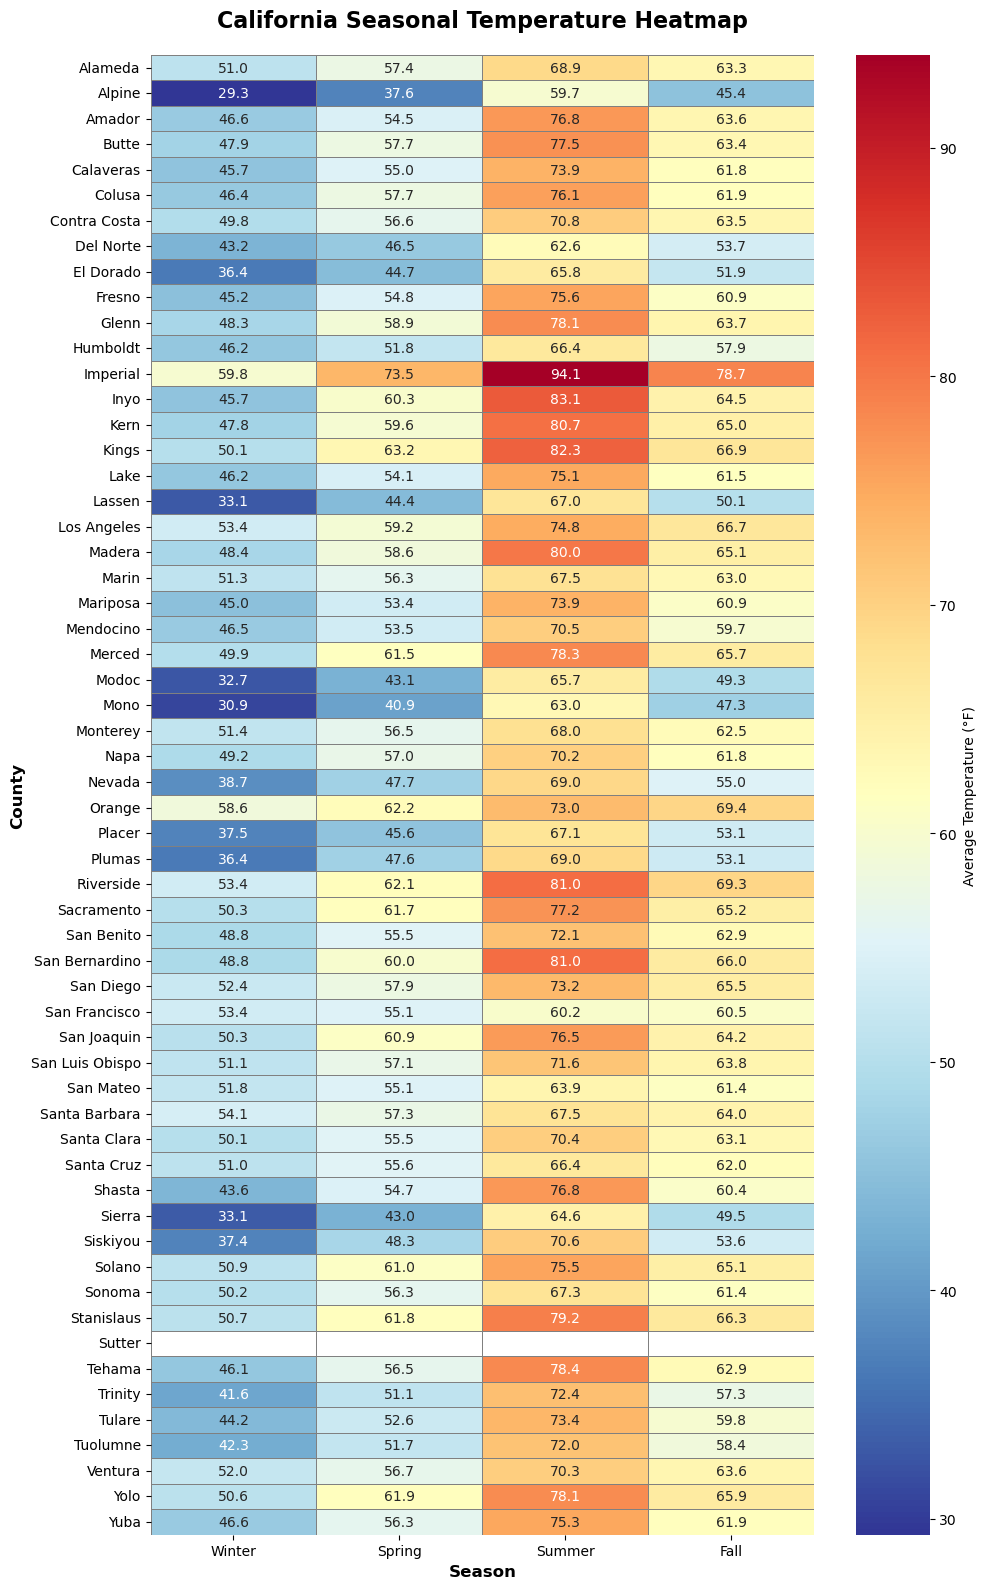

In [ ]:
plt.figure(figsize=(10, 16)) # create figure

# plot heatmap df
sns.heatmap(
    heatmap_data,
    cmap='RdYlBu_r',
    annot=True,
    fmt='.1f',
    cbar_kws={'label': 'Average Temperature (°F)'},
    linewidths=0.5,
    linecolor='gray'
)
plt.title('California Seasonal Temperature Heatmap', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Season', fontsize=12, fontweight='bold')
plt.ylabel('County', fontsize=12, fontweight='bold')
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [23]:


# Calculate county scores WITH WIND (avg , min and MAX)
def calculate_county_scores(df, df_wind):
    scores = []
    df = df[df['county_name'] != 'Sutter']
    
    for county in df['county_name'].unique():
        county_data = df[df['county_name'] == county]
        temp_comfort_score = 0
        temp_stability_score = 0
        precip_score = 0
        
        # Temperature comfort score
        # Getting average temperature estimate by taking average of TAVG over all seasons
        avg_temp = county_data['TAVG'].mean()
        if 60 <= avg_temp <= 70:
            temp_comfort_score = 100
        elif avg_temp < 60:
            temp_comfort_score = max(0, 100 - (60 - avg_temp) * 4)
        elif avg_temp > 70:
            temp_comfort_score = max(0, 100 - (avg_temp - 70) * 4)
        
        # Using range to measure the temperature stability/variation
        temp_range = county_data['TAVG'].max() - county_data['TAVG'].min()
        if temp_range <= 15:
            temp_stability_score = 100
        else:
            temp_stability_score = max(0, 100 - (temp_range - 15) * 4)
        
        # Precipitation score
        # 38 - 102 mm per seasonal month is ideal
        avg_precip = county_data['PRCP'].mean()
        if 38 <= avg_precip <= 102:
            precip_score = 100
        elif avg_precip < 38:
            precip_score = max(0, (avg_precip / 38) * 100 - 20)
            # Want a harsh penalty for way too dry areas
            # Ratio of actual rainfall vs minimum ideal, converts ratio to percentages
            # Applying -20 for the harsh penalty
        elif avg_precip > 102:
            precip_score = max(0, 100 - (avg_precip - 102) * 0.6)

# Summer comfort score
        summer_data = county_data[county_data['season'] == 'Summer']  # Filtered dataframe with only summer row for county
        if not summer_data.empty:
            summer_max = summer_data['TMAX'].values[0]  # Access the TMAX for average monthly max temp in summer, turn into single number
            if summer_max <= 80:
                summer_comfort_score = 100
            elif summer_max <= 90:
                summer_comfort_score = max(0, 100 - (summer_max - 80) * 4)  # Penalize 4
            elif summer_max <= 100:
                summer_comfort_score = max(0, 60 - (summer_max - 90) * 5)
            else:
                # Extreme penalty for 100°F+
                summer_comfort_score = max(0, 10 - (summer_max - 100) * 2)
        else:
            summer_comfort_score = 50
        
        # Winter comfort score
        winter_data = county_data[county_data['season'] == 'Winter']
        if not winter_data.empty:
            winter_min = winter_data['TMIN'].values[0]
            if winter_min >= 40:
                winter_comfort_score = 100
            elif winter_min >= 30:
                winter_comfort_score = max(0, 100 - (40 - winter_min) * 3)
            else:
                winter_comfort_score = max(0, 70 - (30 - winter_min) * 5)
        else:
            winter_comfort_score = 50

# Extreme temperature score
        max_temp_overall = county_data['TMAX'].max()
        min_temp_overall = county_data['TMIN'].min()
        extreme_penalty = 0
        if max_temp_overall > 95:
            extreme_penalty += (max_temp_overall - 95) * 2
        if min_temp_overall < 30:
            extreme_penalty += (30 - min_temp_overall) * 2
        extreme_score = max(0, 100 - extreme_penalty)
        
        # Wind comfort scores
        # Data is in mph
        wind_data = df_wind[df_wind['county_name'] == county]
        if not wind_data.empty:
            avg_wind = wind_data['wind_mean'].mean()
            # Ideal range: 7 - 10 mph (light breeze)
            if 7 <= avg_wind <= 10:
                wind_score = 100
            elif avg_wind < 7:
                # Penalty for too calm (stagnant air)
                wind_score = max(0, 100 - (7 - avg_wind) * 10)
            else:
                # Penalty for too windy
                wind_score = max(0, 100 - (avg_wind - 10) * 8)
        else:
            wind_score = 50  # Default if no wind data
        
        # Overall Climate Score (adjusted weights to include wind)
        climate_score = (
            temp_comfort_score * 0.18 +      # Reduced from 0.20
            temp_stability_score * 0.13 +    # Reduced from 0.15
            precip_score * 0.14 +            # Reduced from 0.15
            summer_comfort_score * 0.28 +    # Reduced from 0.30
            winter_comfort_score * 0.09 +    # Reduced from 0.10
            extreme_score * 0.09 +           # Reduced from 0.10
            wind_score * 0.09                # NEW: 9% weight
        )
        
        scores.append({
            'county_name': county,
            'climate_score': round(climate_score, 1),
            'temp_comfort': round(temp_comfort_score, 1),
            'temp_stability': round(temp_stability_score, 1),
            'precip_score': round(precip_score, 1),
            'summer_comfort': round(summer_comfort_score, 1),
            'winter_comfort': round(winter_comfort_score, 1),
            'extreme_score': round(extreme_score, 1),
            'wind_score': round(wind_score, 1)  # NEW
        })
    
    return pd.DataFrame(scores).sort_values('climate_score', ascending=False)

# TMAX in Summer = Average of the monthly maximum temperatures across summer months
# Example: Average of June max, July max, August max



In [25]:
scores_df = calculate_county_scores(df, df_wind)

In [27]:

# Display top 10
top10 = scores_df.head(10)
print("Top 10 Counties:")
print(top10)

Top 10 Counties:
      county_name  climate_score  temp_comfort  temp_stability  precip_score  \
41  Santa Barbara           98.9         100.0           100.0         100.0   
43     Santa Cruz           98.6          95.1            98.4         100.0   
0         Alameda           98.2         100.0            88.5         100.0   
20          Marin           97.5          98.1            95.0         100.0   
40      San Mateo           96.9          92.0           100.0         100.0   
48         Sonoma           96.7          95.2            91.8         100.0   
26       Monterey           95.7          98.4            93.6         100.0   
42    Santa Clara           95.1          99.2            78.5         100.0   
6    Contra Costa           93.8         100.0            76.1         100.0   
37  San Francisco           93.7          89.2           100.0         100.0   

    summer_comfort  winter_comfort  extreme_score  wind_score  
41           100.0           100.0    

In [29]:
# Display bottom 10
bottom10 = scores_df.tail(10)
print("\nBottom 10 Counties:")
print(bottom10)



Bottom 10 Counties:
       county_name  climate_score  temp_comfort  temp_stability  precip_score  \
49      Stanislaus           69.4         100.0            46.1          57.2   
1           Alpine           69.1          32.1            38.5         100.0   
5           Colusa           65.7         100.0            41.5          52.6   
23          Merced           64.6         100.0            46.3          38.8   
32       Riverside           64.2         100.0            49.3          29.0   
35  San Bernardino           63.3         100.0            31.4          36.5   
14            Kern           61.2         100.0            28.2          26.3   
15           Kings           57.6         100.0            31.4          24.0   
13            Inyo           50.3         100.0            10.5          10.0   
12        Imperial           41.0          74.0            22.9           0.0   

    summer_comfort  winter_comfort  extreme_score  wind_score  
49            37.2     

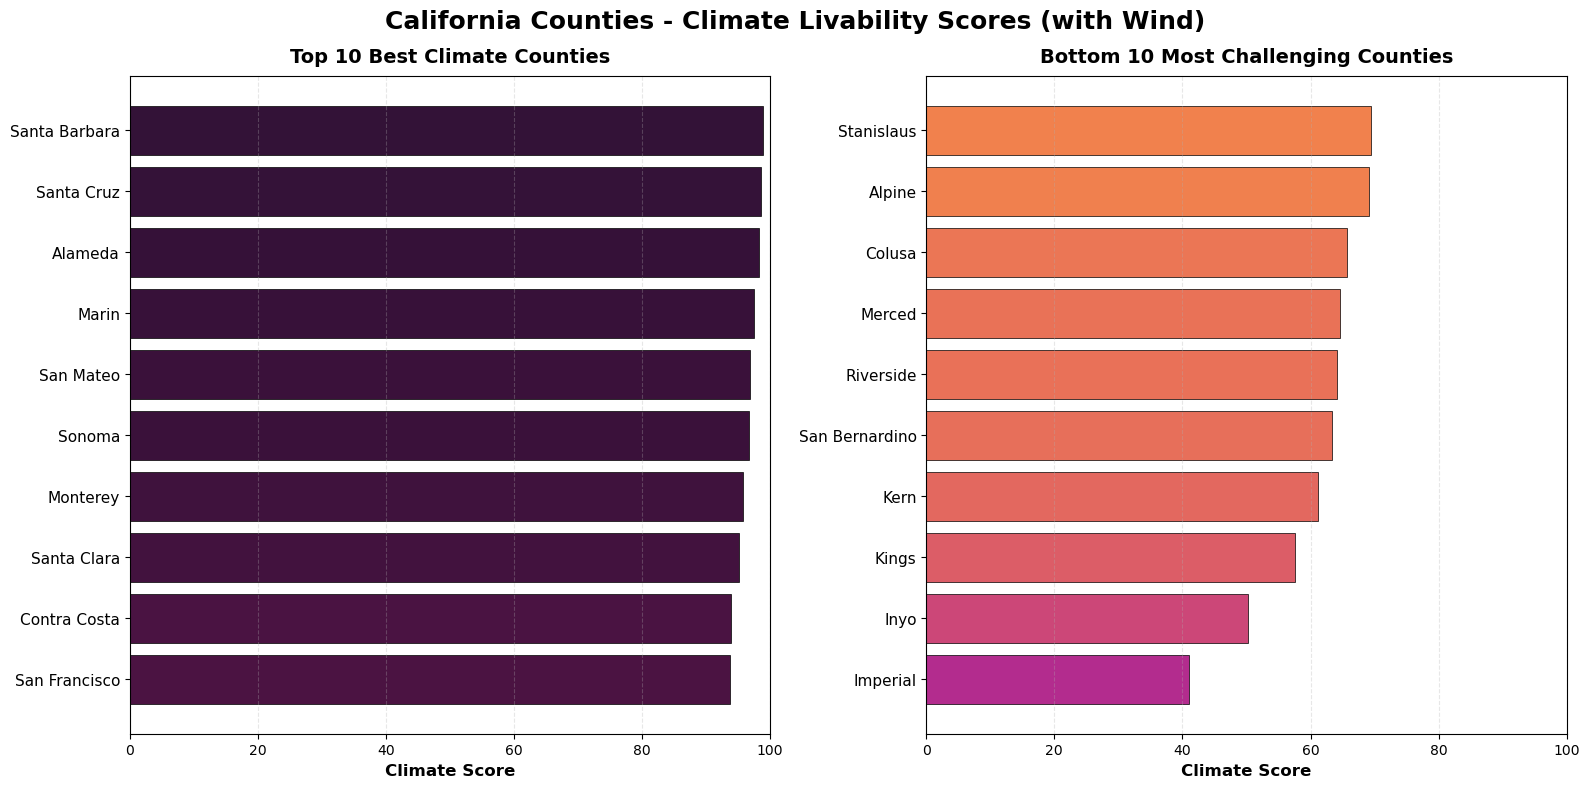

In [31]:
# Figure with 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
fig.suptitle('California Counties - Climate Livability Scores (with Wind)', fontsize=18, fontweight='bold', y=0.98)

# Top 10 counties climate score
ax1 = axes[0]
colors_top = plt.colormaps.get_cmap('twilight_shifted')(top10['climate_score'] / 100)
bars1 = ax1.barh(range(len(top10)), top10['climate_score'], color=colors_top, edgecolor='black', linewidth=0.5)
ax1.set_yticks(range(len(top10)))
ax1.set_yticklabels(top10['county_name'], fontsize=11)
ax1.set_xlabel('Climate Score', fontweight='bold', fontsize=12)
ax1.set_title('Top 10 Best Climate Counties', fontweight='bold', fontsize=14, pad=10)
ax1.set_xlim(0, 100)
ax1.invert_yaxis()
ax1.grid(axis='x', alpha=0.3, linestyle='--')

# Bottom 10 counties climate score
ax2 = axes[1]
colors_bottom = plt.colormaps.get_cmap('plasma')(bottom10['climate_score'] / 100)
bars2 = ax2.barh(range(len(bottom10)), bottom10['climate_score'], color=colors_bottom, edgecolor='black', linewidth=0.5)
ax2.set_yticks(range(len(bottom10)))
ax2.set_yticklabels(bottom10['county_name'], fontsize=11)
ax2.set_xlabel('Climate Score', fontweight='bold', fontsize=12)
ax2.set_title('Bottom 10 Most Challenging Counties', fontweight='bold', fontsize=14, pad=10)
ax2.set_xlim(0, 100)
ax2.invert_yaxis()
ax2.grid(axis='x', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()


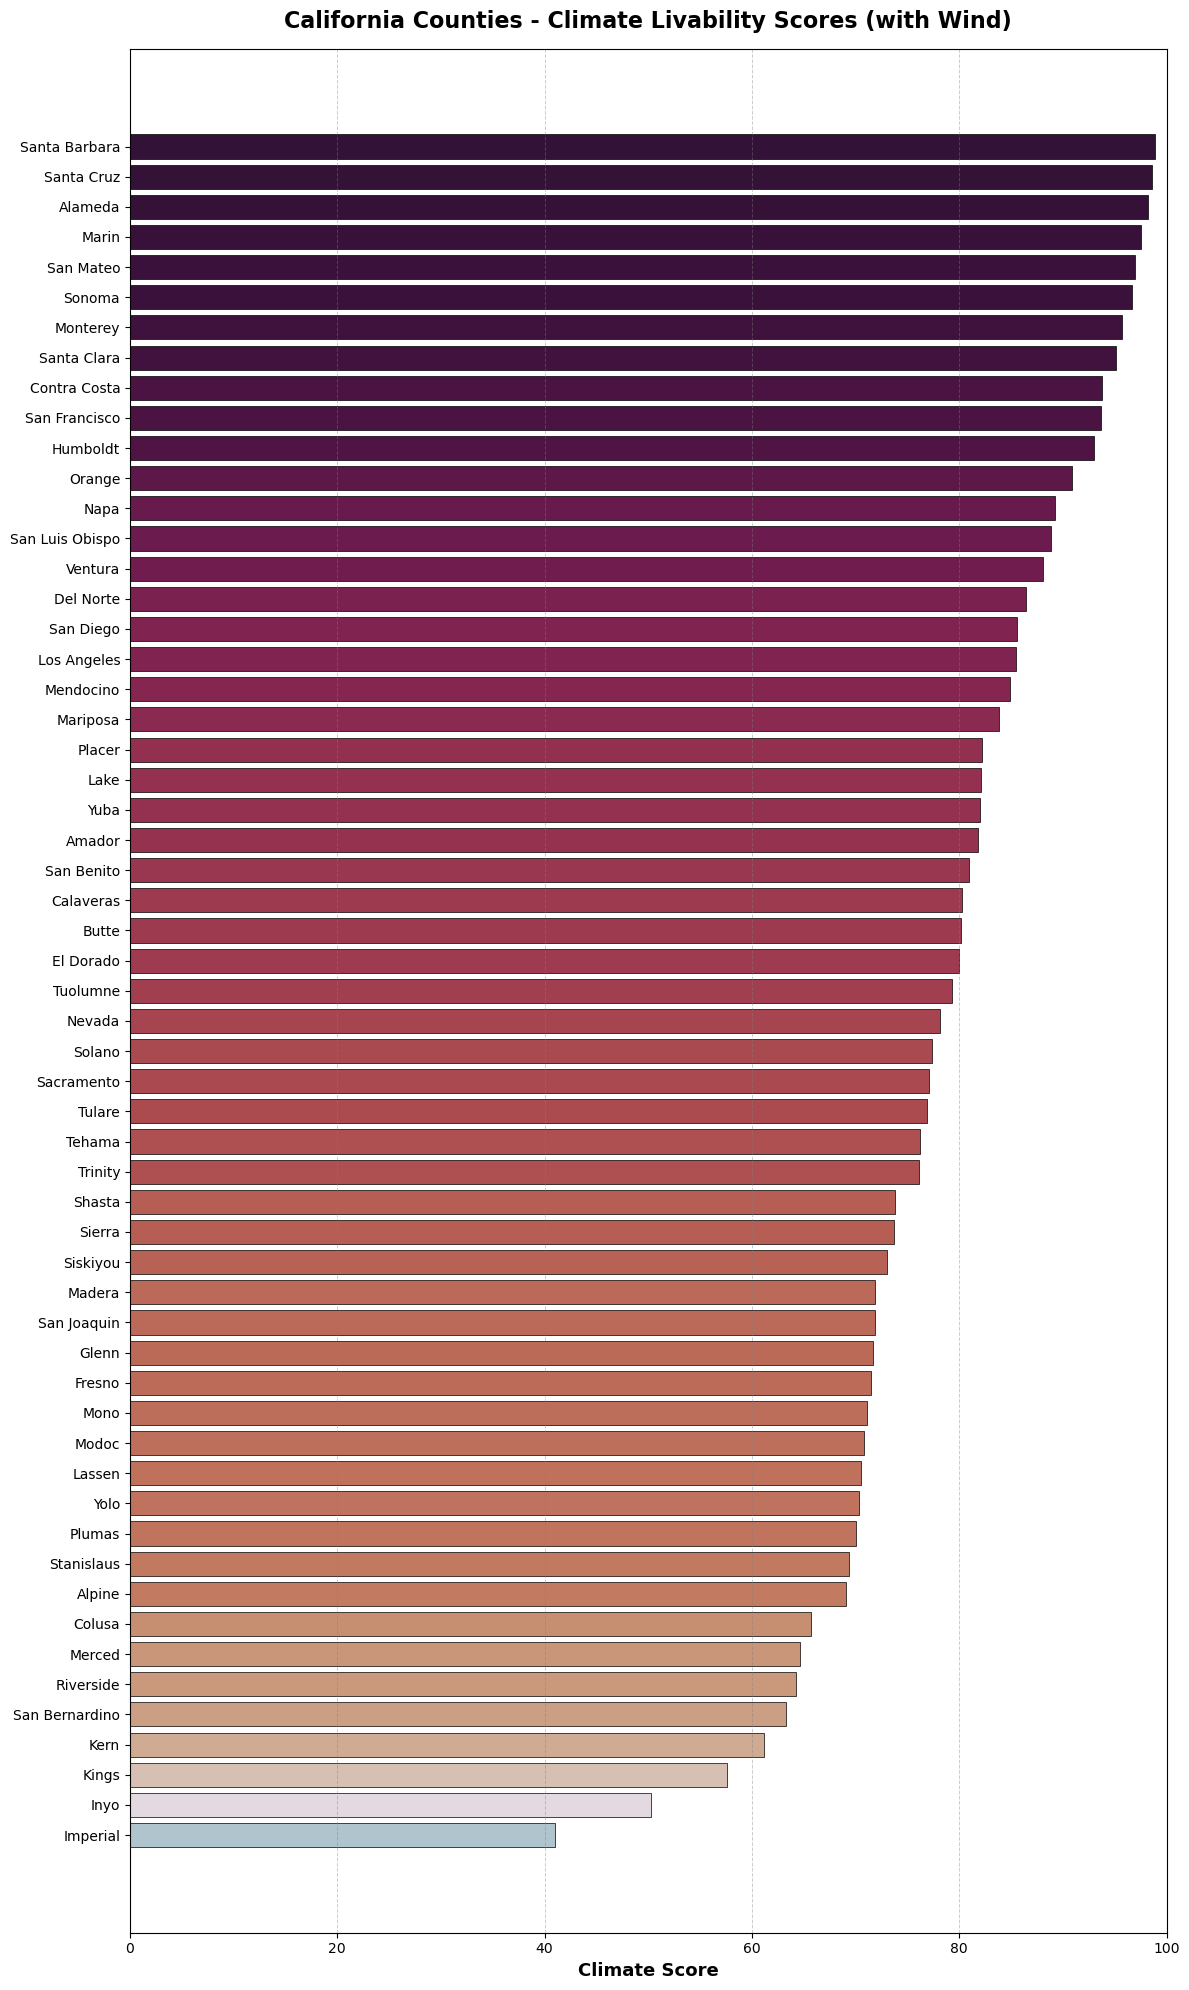

In [ ]:
# Create figure all counties
fig, ax = plt.subplots(figsize=(12, 20))
colors = plt.colormaps.get_cmap('twilight_shifted')(scores_df['climate_score'] / 100)

# Horizontal bar chart
bars = ax.barh(range(len(scores_df)), scores_df['climate_score'], color=colors, edgecolor='black', linewidth=0.5)

# Y-axis labels
ax.set_yticks(range(len(scores_df)))
ax.set_yticklabels(scores_df['county_name'], fontsize=10)

# Labels and title
ax.set_xlabel('Climate Score', fontweight='bold', fontsize=13)
ax.set_title('California Counties - Climate Livability Scores (with Wind)', fontweight='bold', fontsize=16, pad=15)
ax.set_xlim(0, 100)

# Highest to lowest
ax.invert_yaxis()

# Grid for reference
ax.grid(axis='x', alpha=0.4, linestyle='--', linewidth=0.7, color='gray')

plt.tight_layout()
plt.show()

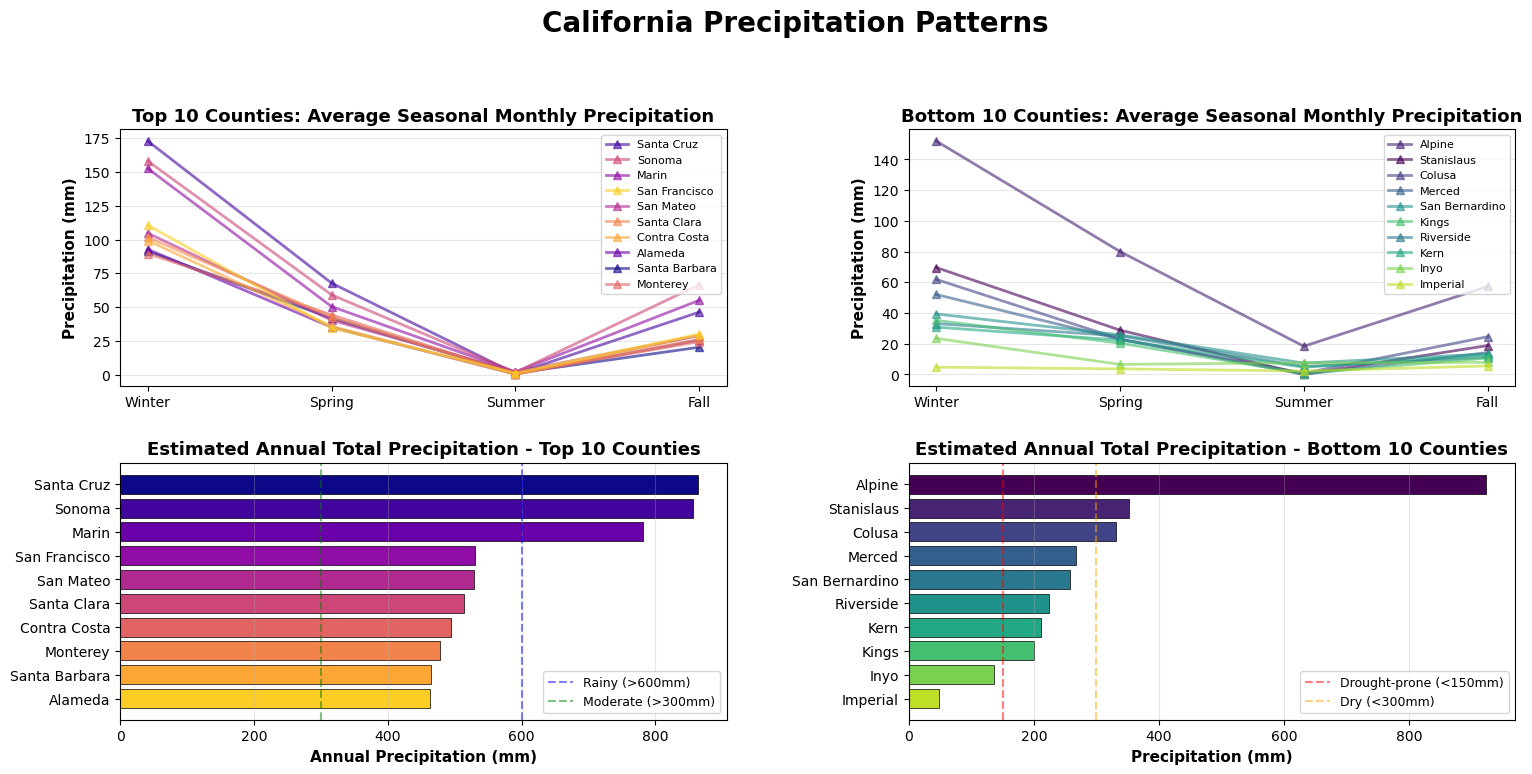

In [47]:

# Top 10 county names
top10_counties = scores_df.head(10)['county_name'].tolist()
bottom10_counties = scores_df.tail(10)['county_name'].tolist()

# Top 10 counties data
top10_data = df[df['county_name'].isin(top10_counties)]
bottom10_data = df[df['county_name'].isin(bottom10_counties)]

# Multiple subplots
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

# Title
fig.suptitle('California Precipitation Patterns', fontsize=20, fontweight='bold', y=0.98)

# Season order
season_order = ['Winter', 'Spring', 'Summer', 'Fall']



# ------- Seasonal Precipitation of top 10 counties --------
ax1 = fig.add_subplot(gs[0, 0])
cmap_top = plt.colormaps.get_cmap('plasma')
colors_top10 = [cmap_top(i/len(top10_counties)) for i in range(len(top10_counties))]  # 10 distinct colors from colormap

for idx, county in enumerate(top10_counties):  # Loop through each county in top 10, gives index and county name
    county_data = top10_data[top10_data['county_name'] == county]  # Filter data to only get data for specific county we are looking at
    county_data = county_data.set_index('season').reindex(season_order)  # Make season index, check if seasons in right order
    ax1.plot(season_order, county_data['PRCP'], marker='^', linewidth=2.0, label=county, alpha=0.6, color=colors_top10[idx])  # Adjust visual elements

ax1.set_ylabel('Precipitation (mm)', fontweight='bold', fontsize=11)
ax1.set_title('Top 10 Counties: Average Seasonal Monthly Precipitation', fontweight='bold', fontsize=13)
ax1.legend(fontsize=8, loc='upper right')
ax1.grid(axis='y', alpha=0.3)

handles, labels = ax1.get_legend_handles_labels()
# Get winter values for sorting
winter_values = []
for county in top10_counties:
    county_data = top10_data[top10_data['county_name'] == county]
    county_data = county_data.set_index('season').reindex(season_order)
    winter_values.append(county_data.loc['Winter', 'PRCP'])

# Sort handles and labels by winter precipitation (highest first)
sorted_pairs = sorted(zip(handles, labels, winter_values), key=lambda x: x[2], reverse=True)
handles_sorted = [p[0] for p in sorted_pairs]
labels_sorted = [p[1] for p in sorted_pairs]
ax1.legend(handles_sorted, labels_sorted, fontsize=8, loc='upper right')






# ------- Seasonal Precipitation of bottom 10 counties -------
ax2 = fig.add_subplot(gs[0, 1])
cmap_bottom = plt.colormaps.get_cmap('viridis')
colors_bottom10 = [cmap_bottom(i/len(bottom10_counties)) for i in range(len(bottom10_counties))]

for idx, county in enumerate(bottom10_counties):
    county_data = bottom10_data[bottom10_data['county_name'] == county]
    county_data = county_data.set_index('season').reindex(season_order)
    ax2.plot(season_order, county_data['PRCP'], marker='^', linewidth=2.0, label=county, alpha=0.6, color=colors_bottom10[idx])

ax2.set_ylabel('Precipitation (mm)', fontweight='bold', fontsize=11)
ax2.set_title('Bottom 10 Counties: Average Seasonal Monthly Precipitation', fontweight='bold', fontsize=13)
ax2.legend(fontsize=8, loc='upper right')
ax2.grid(axis='y', alpha=0.3)

handles, labels = ax2.get_legend_handles_labels()
# Get winter values for sorting
winter_values = []
for county in bottom10_counties:
    county_data = bottom10_data[bottom10_data['county_name'] == county]
    county_data = county_data.set_index('season').reindex(season_order)
    winter_values.append(county_data.loc['Winter', 'PRCP'])

# Sort handles and labels by winter precipitation (highest first)
sorted_pairs = sorted(zip(handles, labels, winter_values), key=lambda x: x[2], reverse=True)
handles_sorted = [p[0] for p in sorted_pairs]
labels_sorted = [p[1] for p in sorted_pairs]
ax2.legend(handles_sorted, labels_sorted, fontsize=8, loc='upper right')








# ------- Annual total precipitation for top 10 ---------
ax3 = fig.add_subplot(gs[1, 0])
# Adding up season average totals *3 to account for the fact that 3 months in averages for each season
top10_annual = (top10_data.groupby('county_name')['PRCP'].sum() * 3).sort_values(ascending=False)

# Plasma colormap
cmap_top10 = plt.colormaps.get_cmap('plasma')
colors_top = [cmap_top10(i/len(top10_annual)) for i in range(len(top10_annual))]

ax3.barh(range(len(top10_annual)), top10_annual.to_numpy(), color=colors_top, edgecolor='black', linewidth=0.5)
ax3.set_yticks(range(len(top10_annual)))
ax3.set_yticklabels(top10_annual.index.to_list(), fontsize=10)
ax3.set_xlabel('Annual Precipitation (mm)', fontweight='bold', fontsize=11)
ax3.set_title('Estimated Annual Total Precipitation - Top 10 Counties', fontweight='bold', fontsize=13)
ax3.invert_yaxis()
ax3.grid(axis='x', alpha=0.3)

# Rainy and moderate label
ax3.axvline(x=600, color='blue', linestyle='--', linewidth=1.5, alpha=0.5, label='Rainy (>600mm)')
ax3.axvline(x=300, color='green', linestyle='--', linewidth=1.5, alpha=0.5, label='Moderate (>300mm)')
ax3.legend(fontsize=9, loc='lower right')






# ------- Annual total precipitation for bottom 10 ---------
ax4 = fig.add_subplot(gs[1, 1])
# Adding up season average totals *3 to account for the fact that 3 months in averages for each season
bottom10_annual = (bottom10_data.groupby('county_name')['PRCP'].sum() * 3).sort_values(ascending=False)

# Viridis colormap
cmap_bottom10 = plt.colormaps.get_cmap('viridis')
colors_bottom = [cmap_bottom10(i/len(bottom10_annual)) for i in range(len(bottom10_annual))]

ax4.barh(range(len(bottom10_annual)), bottom10_annual.to_numpy(), color=colors_bottom, edgecolor='black', linewidth=0.5)
ax4.set_yticks(range(len(bottom10_annual)))
ax4.set_yticklabels(bottom10_annual.index.to_list(), fontsize=10)
ax4.set_xlabel('Precipitation (mm)', fontweight='bold', fontsize=11)
ax4.set_title('Estimated Annual Total Precipitation - Bottom 10 Counties', fontweight='bold', fontsize=13)
ax4.invert_yaxis()
ax4.grid(axis='x', alpha=0.3)

# Drought prone label
ax4.axvline(x=150, color='red', linestyle='--', linewidth=1.5, alpha=0.5, label='Drought-prone (<150mm)')
ax4.axvline(x=300, color='orange', linestyle='--', linewidth=1.5, alpha=0.5, label='Dry (<300mm)')
ax4.legend(fontsize=9, loc='lower right')

plt.show()